蒙特卡洛模拟通过随机生成股价序列进行一系列模拟操作，因此首先需要我们事先定义模拟的股票路径，通常模拟路径如下：

$S_t=S_{(t-1)}×e^{((r-0.5σ^2)T/M+σε√(T/M))}$                                                   
式中S为股票价格，r为无风险利率，T为距离到期日的时间，M为分割的交易日的天数，ε为随机正态生成数。
单纯的模拟算法并不能计算每个时刻的持有期望收益，LSM对于处理美式期权和一些路径依赖的期权定价问题有明显优势。LSM采用了由后往前逆推估计期权路径上时点的期望价值的方法，其中在计算过程中，在美式期权执行的边界条件上，通常假设当提前履约的价差大于持有的期望价值时选择执行期权，反之则继续持有，即每一时刻的当期价值为max⁡(S_T-K,0)，最后再通过贴现每一路径的价值获得该时点的平均看涨期权价值。如前文所说，计算每一时间点的期望价值时，LSM会构建基于基函数的线性函数，且常采用多项式，随后利用最小二乘法来确定继续持有期权的价值。假设V是贴现价格，且该贴现值为风险中性世界中条件期望值，建立如下最小二乘关系式。

$V=a+bS_t+cS_t^2+dS_t^3 $             

式中参数a,b,c和d通过最优解求出。因为复杂的计算过程和大量的交易时间点，最小二乘蒙特卡洛模拟算法的最大缺点便体现在模拟路径会随着时间点的增大而增大，因此运算量极大，需要消耗较多的时间。


In [ ]:
from math import log,sqrt,exp,ceil
import numpy as np
import numpy.random as npr

In [172]:
def gen_sn(M,I,anti_paths=True,mo_match=True): 
    """
# 生成随机值（运用方差缩减-对偶方法或者矩匹配的方法，改善正态分布随机值的匹配
    Function to generate random numbers for simulation
    :param M: number of time  intervals for discretization
    :param I: number of paths to be simulated
    :param anti_paths: use of antithetic variates
    :param mo_math: use of moment matching
    :return:
    """

    if anti_paths is True:
    #对偶方法
        sn = npr.standard_normal((M+1,int(I / 2)))
        sn = np.concatenate((sn,-sn), axis=1) 
    else:
        sn = npr.standard_normal((M+1,I))
    if mo_match is True:
    #矩匹配
        sn = (sn - sn.mean())/sn.std()
    return sn


def gbm_mcs_stat(K):
    """
    Valuation of European call option in Black-Scholes-Merton
    by Mont Carlo simulation ( of index level at maturity )
    :param k: float (positive) strike price of the option
    :return:
    """
    sn = gen_sn(1, I)
    # simulate index level at maturity
    ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * sn[1])
    # calculate payoff at maturity
    hT = np.maximum(ST - K, 0)
    # calculate MCS estimator
    C0 = np.exp(-r * T) * 1 / I * np.sum(hT)
    return C0

def gbm_mcs_amer(K, option='call'):
    """
    Valuation of American option in Black-Scholes-Merton
    by Monte Carlo simulation by LSM algorithm
    :param K: (positive) strike price of the option
    :param option: type of the option to be valued ('call','put')
    :return: estimated present value of American call option
    """
    dt = T / M
    df = np.exp(-r * dt)
    # simulation of index levels
    S = np.zeros((M + 1, I))
    S[0] = S0
    sn = gen_sn(M, I)
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt
                                 + sigma * np.sqrt(dt) * sn[t])
    # case-based calculation of payoff
    if option == 'call':
        h = np.maximum(S - K, 0)
    else:
        h = np.maximum(K - S, 0)
    # LSM algorithm
    V = np.copy(h)
    for t in range(M - 1, 0, -1):
        reg = np.polyfit(S[t], V[t + 1] * df, 7)
        C = np.polyval(reg, S[t])
        V[t] = np.where(C > h[t], V[t + 1] * df, h[t])
    # MSC estimator
    C0 = df * 1 / I * np.sum(V[1])
    return C0

In [ ]:
M = 953
S0 = 52.31
r = 0.0238 #风险中性世界里的收益率期望
sigma = Ready_002460_Price_Final.iloc[0,12] #波动率
T = 3.783562 #T时刻
I = 10000
gbm_mcs_amer(42.28,option='call')

In [175]:
Ready_600998_Price_Final_LSM['LSM_Call_Predict']=0
Ready_600998_Price_Final_LSM['LSM_Convertible_Price']=0
Ready_600998_Price_Final_LSM

,日期,收盘价,成交额(万元),收益率,转股溢价率,纯债价值,期权价值,正股价格,到期时间,转股价格,...,G_L_Predict_Price,J_L_Predict_Price,W_L_Predict_Price,GJ_L_Predict_Price,GW_L_Predict_Price,JW_L_Predict_Price,GJW_L_Predict_Price,GJW_Predict_Price,LSM_Call_Predict,LSM_Convertible_Price
日期,,,,,,,,,,,,,,,,,,,,,
2020-03-25,2020/3/25,119.50,1895.60,-4.70%,26.47%,99.789622,19.710378,17.31,1.810959,18.32,...,118.145149,117.938288,118.250771,118.120071,117.328132,118.161785,118.261578,117.982398,0,0
2020-03-26,2020/3/26,119.63,2064.29,-4.77%,24.95%,99.803897,19.826103,17.54,1.808219,18.32,...,118.891824,118.472916,119.364736,118.810812,117.764597,118.719293,119.115672,118.550639,0,0
2020-03-27,2020/3/27,119.09,922.54,-4.53%,26.04%,99.818175,19.271825,17.31,1.805479,18.32,...,118.243526,117.479185,118.949155,117.991643,116.932514,117.961505,118.262646,117.786389,0,0
2020-03-30,2020/3/30,117.76,1897.45,-3.95%,25.50%,99.861021,17.898979,17.19,1.797260,18.32,...,117.939337,117.073672,118.734143,117.515226,116.730981,117.907157,117.690472,117.539553,0,0
2020-03-31,2020/3/31,116.45,1865.18,-3.35%,25.49%,99.875307,16.574693,17.00,1.794521,18.32,...,117.687323,116.236833,118.233611,116.946835,116.358707,117.211152,116.945180,116.874573,0,0
2020-04-01,2020/4/1,116.26,761.78,-3.26%,25.88%,99.889595,16.370405,16.92,1.791781,18.32,...,117.579933,115.697516,118.014143,116.765595,115.984248,116.992551,116.335140,116.836788,0,0
2020-04-02,2020/4/2,116.04,1637.12,-3.17%,26.01%,99.903885,16.136115,16.87,1.789041,18.32,...,117.652374,115.247195,118.013742,116.482951,116.234004,116.816321,115.912980,116.866209,0,0
2020-04-03,2020/4/3,117.31,4890.37,-3.77%,22.11%,99.918178,17.391822,17.60,1.786301,18.32,...,120.039194,117.684075,120.274653,119.541362,118.520211,119.039758,118.034938,119.064695,0,0
2020-04-07,2020/4/7,119.88,1765.98,-4.96%,22.90%,99.975367,19.904633,17.87,1.775342,18.32,...,120.699493,119.409187,121.369250,120.078674,119.249474,120.371237,118.967434,120.046249,0,0


In [189]:
for i in range(0,len(Ready_600998_Price_Final_LSM)):
    sigma = Ready_600998_Price_Final_LSM.iloc[i,21] #波动率
    M = 455-i
    S0 = Ready_600998_Price_Final_LSM.iloc[i,7]
    r = 0.0266 #风险中性世界里的收益率期望
    T = Ready_600998_Price_Final_LSM.iloc[i,8] #T时刻
    I = 50000
    Ready_600998_Price_Final_LSM.iloc[i,39]=gbm_mcs_amer(18.32,option='call')
    Ready_600998_Price_Final_LSM.iloc[i,38]=Ready_600998_Price_Final_LSM.iloc[i,39]*Ready_600998_Price_Final_LSM.iloc[i,25]+Ready_600998_Price_Final_LSM.iloc[i,5]
    print(Ready_600998_Price_Final_LSM.iloc[i,38])

C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


117.30489416497558


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


118.08180899528536


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


117.00725441056257


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


116.8860003290369


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


116.48881942682996


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


116.40946428674138


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


116.16876770120307


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


118.37519041776454


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


119.46778139120764


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


119.91915658110757


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


120.34699821164561


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


118.3416922503296


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


119.15014203861456


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


118.17003214986153


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


118.16054970191686


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


117.88047848819414


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


117.21358423830588


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


118.01605681425966


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


120.35281754441101


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


127.01958437991007
126.39249135500631


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


In [ ]:
for i in range(0,len(Ready_600998_Price_Final_LSM)):
    sigma = Ready_600998_Price_Final_LSM.iloc[i,21] #波动率
    M = 455-i
    S0 = Ready_600998_Price_Final_LSM.iloc[i,7]
    r = 0.0266 #风险中性世界里的收益率期望
    T = Ready_600998_Price_Final_LSM.iloc[i,8] #T时刻
    I = 50000
    Ready_600998_Price_Final_LSM.iloc[i,39]=gbm_mcs_amer(18.32,option='call')
    Ready_600998_Price_Final_LSM.iloc[i,38]=Ready_600998_Price_Final_LSM.iloc[i,39]*Ready_600998_Price_Final_LSM.iloc[i,25]+Ready_600998_Price_Final_LSM.iloc[i,5]
    print(Ready_600998_Price_Final_LSM.iloc[i,38])

In [190]:
Ready_600998_Price_Final_LSM.to_csv("./Ready_600998_Price_Final_LSM.csv",encoding='gbk')

In [252]:
Ready_600998_Price_Final_temp=Ready_600998_Price_Final_LSM[['收盘价','GJW_L_Predict_Price']].copy()
Ready_600998_Price_Final_temp['Pianli_rate']=(Ready_600998_Price_Final_temp['GJW_L_Predict_Price']-Ready_600998_Price_Final_temp['收盘价'])/Ready_600998_Price_Final_temp['收盘价']
Ready_600998_Price_Final_temp['Pianli_rate'].mean()

-0.0012554938842967908

In [253]:
Ready_600998_Price_Final_temp['Resid']=Ready_600998_Price_Final_temp['GJW_L_Predict_Price']-Ready_600998_Price_Final_temp['收盘价']
Ready_600998_Price_Final_temp['Resid_abs']=Ready_600998_Price_Final_temp['Resid'].abs()
Ready_600998_Price_Final_temp['Resid_square']=Ready_600998_Price_Final_temp['Resid']*Ready_600998_Price_Final_temp['Resid']

In [254]:
Ready_600998_Price_Final_temp['Resid_abs'].mean()

1.1857456409294826

In [254]:
Ready_600998_Price_Final_temp['Resid_abs'].mean()

1.1857456409294826

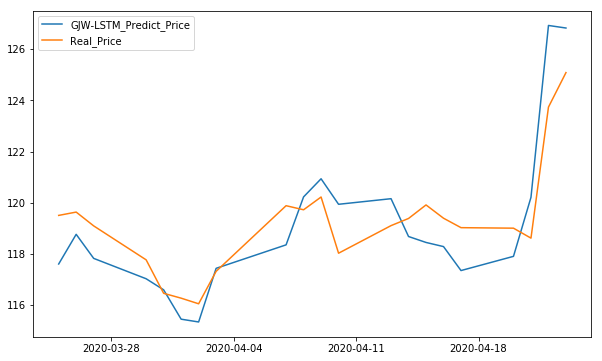

In [257]:
plt.figure(figsize=(10,6))
plt.plot(Ready_600998_Price_Final_LSM['GJW_L_Predict_Price'])
plt.plot(Ready_600998_Price_Final_LSM['收盘价'])
plt.legend(["GJW-LSTM_Predict_Price","Real_Price"])